# Room temperature Langevin fitting 

Jupyter notebook for Room temperature langevin fitting using a size distribution obtained from SAXS

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Load Data

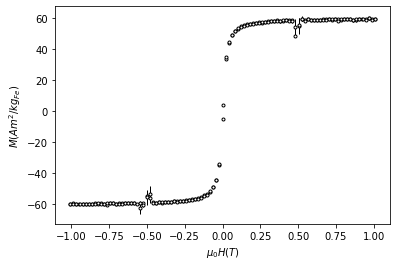

In [3]:
# load data
x,y,ey = np.loadtxt("Hysteresis_OC15_P_B3a_300K.dat", usecols=(2,4,5), unpack=True, delimiter=",", skiprows=31)

# subtract background
y +=2.255e-8*x

# convert x into Tesla
x /= 10000

# normalize to iron content from ICP-OES
y /= 1.363e-6
ey /= 1.363e-6

#normalize data to amount of iron present in iron oxide mixture, i.e. 70%
y *= 0.7
ey *= 0.7

# plot data
fig,ax = plt.subplots()
ax.errorbar(x,y,ey,linewidth=0, marker='.',markerfacecolor=(1,1,1), color=(0,0,0), ecolor=(0,0,0), elinewidth=1)
ax.set_ylabel("$M (Am^2/kg_{Fe})$")
ax.set_xlabel("$\mu_0H (T)$"); # semicolon suppresses return statement of pyplot

## Lognormal size distribution

The lognormal size distribution is defined as:
$D_N(R,R0,S)=\frac{1}{(2\pi)^{1/2}SR}\exp\left[-\frac{\ln^2(R/R_0)}{2S^2}\right]$

In [4]:
def lognorm(r,s,r0):
    y = -(np.log(r/r0)**2)/(2*s**2)
    pdf = 1/(np.sqrt(2*np.pi)*s*r)*np.exp(y)
    return pdf

Integral: 1.000000


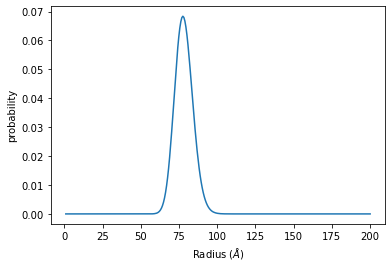

In [5]:
r_range = np.linspace(1,200,300)
plt.plot(r_range, lognorm(r_range,0.075,78))
plt.xlabel("Radius ($\AA$)")
plt.ylabel("probability")
integral = quad(lognorm,40,125, args=(0.075,78))
print("Integral: %2f" % integral[0])

## Langevin fit with size distribution

The field dependent magnetization M(H) at room temperature for non-interacting nanoparticles with a lognormal size distribution is described by:

$M(B,T) = \int_{0}^{\infty}M_{sat} L\left(\frac{\mu_p B}{k_B T}\right)P(v)dv$, 

where $P(v)$ is the size distribution as given above and $L(x)$ is the Langevin function according to $L(x) = \coth(x)-1/x = 1/\tanh(x)-1/x$. $\mu_p$ is the particle magentic moment, $k_B$ is the Boltzmann constant and $T$ is the temperature in Kelvin. $M_{sat}$ relates to the particle magnetic moment via $M_{sat}=\mu_p/(V_{total}\rho)$, therefore the equation for M can be rewritten to 

$M(B,T) = \int_{0}^{\infty}\frac{\mu_p}{V_{total}\rho} L\left(\frac{\mu_p B}{k_B T}\right)P(v)dv$

In [6]:
# Bohr magneton in J/T
uB = 9.2740100783e-24
# Boltzmann constant in J/K
kB = 1.380649e-23

In [12]:
def langevin(x,up,bkg):
    # up in units of uB
    V = 4/3*np.pi*(7.8e-9)**3
    M_sat = up*uB/(V*4.95e3)
    b = up*uB*x/(kB*300)
    return M_sat*(1/np.tanh(b)-1/(b))+bkg*x

def fit_langevin(x,y,ey):
    popt,pcov = curve_fit(langevin, x,y,sigma=ey)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

Langevin Fit particle magnetic moment: 62230 μB


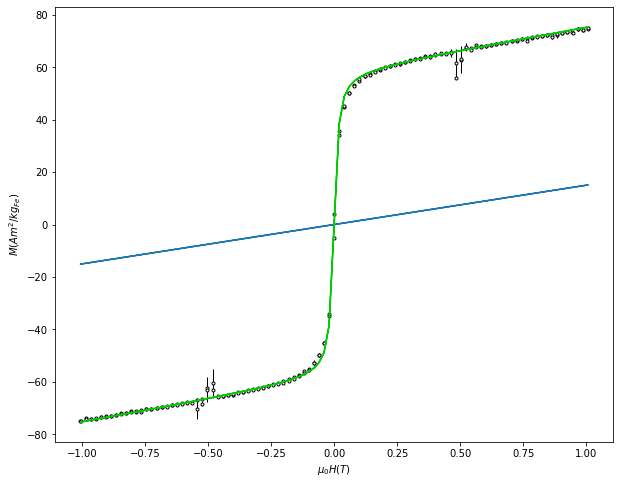

In [17]:
fig,ax = plt.subplots(figsize=(10,8))
bkg = 15.0*x
ax.plot(x,bkg)
ax.errorbar(x,y+bkg,ey,linewidth=0, marker='.',markerfacecolor=(1,1,1), color=(0,0,0), ecolor=(0,0,0), elinewidth=1)
popt,perr = fit_langevin(x,y+bkg,ey)
y_fit = langevin(x, *popt)
ax.errorbar(x,y_fit, color=(0,0.8,0))
print("Langevin Fit particle magnetic moment: %.0f \u03BCB" % (popt[0]))
ax.set_ylabel("$M (Am^2/kg_{Fe})$")
ax.set_xlabel("$\mu_0H (T)$");

The particle magnetic moment $\mu_p$ is defined as: $\mu_p=VM_{sat}$

In [84]:
def langevin_r(x,R,Ms):
    # R in angstrom, density in kg/m^3
    density = 4.95e3
    V = 4/3*np.pi*(R*1e-10)**3
    up = V * Ms * density
    return Ms*(1/np.tanh(up*x/(kB*300))-1/(up*x/(kB*300)))

def langevin_r_2()

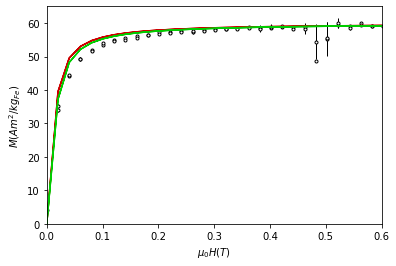

In [86]:
fig,ax = plt.subplots()
ax.set_ylabel("$M (Am^2/kg_{Fe})$")
ax.set_xlabel("$\mu_0H (T)$")
ax.set_xlim(0,0.6)
ax.set_ylim(0,65)

#data
ax.errorbar(x,y,ey,linewidth=0, marker='.',markerfacecolor=(1,1,1), color=(0,0,0), ecolor=(0,0,0), elinewidth=1)

#calculated, with R=7.8nm
ax.errorbar(x,langevin_r(x,78,60), color=(0.8,0,0))

#calculated, with R=7.5nm, i.e. with dead surface layer
ax.errorbar(x,langevin_r(x,75,60), color=(0,0.8,0));

In [150]:
def integrand(r,x,r0,s,ms):
    return lognorm(r,s,r0)*langevin_r(x,r,ms)
    
def integral_sizedist(x,r0,s,ms):
    M = np.zeros_like(x)
    for i in range(len(x)):
        M[i] += quad(integrand, 40, 120, args=(x[i],r0,s,ms))[0]
    return M

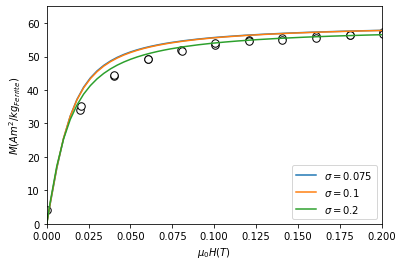

In [151]:
fig,ax = plt.subplots()
ax.set_ylabel("$M (Am^2/kg_{Ferrite})$")
ax.set_xlabel("$\mu_0H (T)$")
ax.set_xlim(0,0.2)
ax.set_ylim(0,65)

#data
ax.errorbar(x,y,ey,linewidth=0, 
            marker='.',
            markerfacecolor=(1,1,1), 
            color=(0,0,0), 
            ecolor=(0,0,0), 
            elinewidth=1,
            markersize=15)

#calculated with size distribution, using different values for the sigma parameter
x_calc = np.linspace(-1,1,500)
R = 78
Ms = 60
ax.errorbar(x_calc,integral_sizedist(x_calc,R,0.075,Ms), label=r"$\sigma = 0.075$")
ax.errorbar(x_calc,integral_sizedist(x_calc,R,0.1,Ms), label=r"$\sigma = 0.1$")
ax.errorbar(x_calc,integral_sizedist(x_calc,R,0.2,Ms), label=r"$\sigma = 0.2$")
ax.legend();

## Comparison of reduced moment and field dependent moment

59.43501632428467
1.196652278691919e-22
1.9877987692617916e-24
59.19653901808419


/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


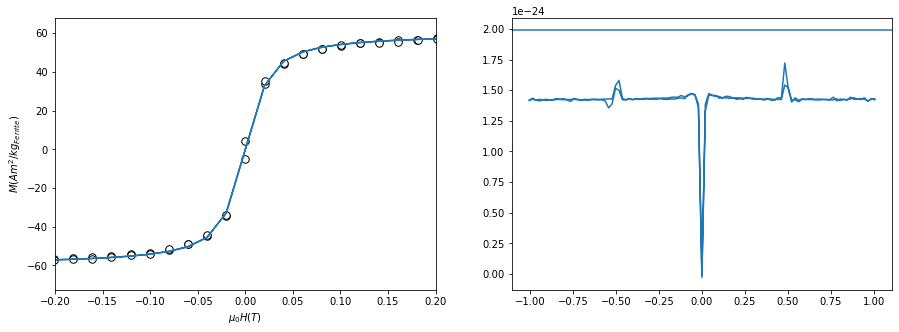

In [249]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_ylabel("$M (Am^2/kg_{Ferrite})$")
ax1.set_xlabel("$\mu_0H (T)$")
ax1.set_xlim(-0.2,0.2)
#ax1.set_ylim(-10,65)

ax1.errorbar(x,y,ey,linewidth=0, 
            marker='.',
            markerfacecolor=(1,1,1), 
            color=(0,0,0), 
            ecolor=(0,0,0), 
            elinewidth=1,
            markersize=15,
            label="300K data")

def langevin(x,up):
    # up in units of uB
    M_sat = 60
    V = M_sat/(up*uB*4.95e3)
    #V = 4/3*np.pi*(7.8e-9)**3
    #M_sat = up*uB/(V*4.95e3)
    b = up*uB*x/(kB*300)
    return M_sat*(1/np.tanh(b)-1/(b))

def gauss(x,s, dmax, dmin):
    return (dmax-dmin)*np.exp(-1/2*(x**2/s**2)) + dmin

def meff(x,ms, R, dmax, dmin, s, s_s, d_s_max, d_s_min):
    V_t = 4/3*np.pi*(R*1e-10)**3
    V_APB = np.pi*(R*1e-10)**2*(gauss(x,s,dmax,dmin))*1e-10
    V_surf = 4/3 * np.pi*((R*1e-10)**3-((R*1e-10)-gauss(x,s_s,d_s_max,d_s_min)*1e-10)**3)
    return (V_t - V_APB - V_surf)*ms*4.95e3

def langevin_mH(x,s,m_min):
    M = langevin(x, -1*gauss(x,s,m_min,0)+63303)
    return M

def fit_langevin_mH():
    popt,pcov = curve_fit(langevin_mH, x,y,sigma=ey)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

def l_func(x,up):
    b = up*uB*x/(kB*300)
    return 1/np.tanh(b)-1/b
    

popt,pcov=fit_langevin_mH()
ax1.errorbar(x, langevin_mH(x,*popt))

print(y[1])

m_eff = -1*gauss(x,popt[0],popt[1],0)+63303

#plt.plot(x,m_eff)

def V_from_mup(x,y,m_eff):
    V_eff = m_eff*uB/(4.95e3*y)*l_func(x,m_eff)
    return V_eff

print(63303*uB/(4.95e3*59)*langevin(0.9,63303))
print(4/3*np.pi*(7.8e-9)**3)
print(63303*uB/(4.95e3*(4/3*np.pi*(7.8e-9)**3)) * l_func(0.9,63303))

V_eff = V_from_mup(x,y,m_eff)
ax2.axhline(4/3*np.pi*(7.8e-9)**3)
ax2.plot(x,V_eff)
#ax2.y_lim()


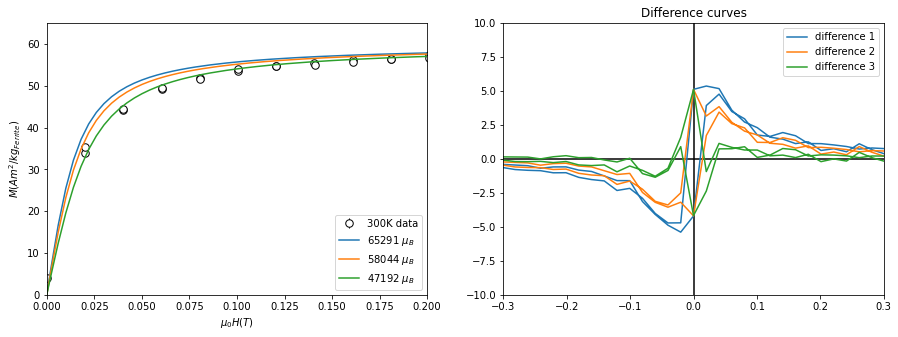

In [242]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_ylabel("$M (Am^2/kg_{Ferrite})$")
ax1.set_xlabel("$\mu_0H (T)$")
ax1.set_xlim(0,0.2)
ax1.set_ylim(0,65)

ax1.errorbar(x,y,ey,linewidth=0, 
            marker='.',
            markerfacecolor=(1,1,1), 
            color=(0,0,0), 
            ecolor=(0,0,0), 
            elinewidth=1,
            markersize=15,
            label="300K data")

x_calc = np.linspace(-1,1,500)
Ms = 60

ax2.set_xlim(-0.3,0.3)
ax2.set_ylim(-10,10)
ax2.axhline(0, color=(0,0,0))
ax2.axvline(0, color=(0,0,0))
ax2.set_title("Difference curves")

def moment(R):
    return 4/3*np.pi*(R*1e-10)**3 * 60 * 4.95e3/uB

def integrand_m(r,s,r0):
    return lognorm(r,s,r0)*moment(r)

def integral_moment(r0):
    s = 0.075
    integral = quad(integrand_m, 0,np.inf, args=(s,r0))[0]
    return integral

# 1. Calculated with full volume: R = 78 A
ax1.errorbar(x_calc,integral_sizedist(x_calc,78,0.075,Ms), label=r"%.0f $\mu_B$" %(integral_moment(78)))
ax2.errorbar(x, integral_sizedist(x,78, 0.075, Ms)-y, label="difference 1")

# 1. Calculated with effective volume: R-d_surf = 75 A
ax1.errorbar(x_calc,integral_sizedist(x_calc,75,0.075,Ms), label=r"%.0f $\mu_B$" %(integral_moment(75)))
ax2.errorbar(x, integral_sizedist(x,75, 0.075, Ms)-y, label="difference 2")

# 2. Calculated with further reduced effective volume to achieve curvature
ax1.errorbar(x_calc,integral_sizedist(x_calc,70,0.075,Ms), label=r"%.0f $\mu_B$" %(integral_moment(70)))
ax2.errorbar(x, integral_sizedist(x,70, 0.075, Ms)-y, label="difference 3")

ax1.legend()
ax2.legend();


Magnetic particle moment from SANS can be calculated via: $\mu_p = \frac{SLD_m V_{eff} \mu_B}{C}$, where C is a constant ($C=2.7e^{-15} m$). $SLD_m$ was found to be $9.4(2)e^{13} m^{-2}$, with a surface layer of $0.3(1) nm$ leading to an effective magnetic radius of $7.5(1) nm$.

Moment from SANS: 61523 μB
Integral moment from SANS: 63102 μB
Integral moment from SANS with total volume: 70980 μB


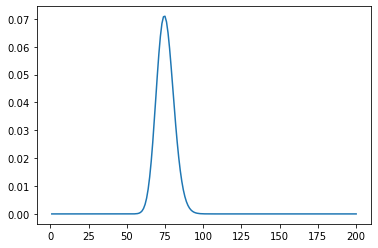

In [197]:
SLD_m = 9.4e13
C = 2.7e-15

def moment_SANS(R,SLD_m):
    return SLD_m*4/3*np.pi*(R*1e-10)**3*uB/C

plt.plot(np.linspace(1,200,200),lognorm(np.linspace(1,200,200),0.075,75))

def integrand_m_SANS(r,s,r0):
    return lognorm(r,s,r0)*4/3*np.pi*(r*1e-10)**3

def integral_moment_SANS(SLD_m,r0):
    # r0 in angstrom, SLD_m in 1/m^2
    s = 0.075
    integral_V = quad(integrand_m_SANS, 0,200, args=(s,r0))[0]
    moment = SLD_m*integral_V/C
    return moment

print("Moment from SANS: %.0f \u03BCB" % (moment_SANS(75,SLD_m)/uB))
print("Integral moment from SANS: %.0f \u03BCB" % (integral_moment_SANS(SLD_m, 75)))


In [193]:
def ratio_volume(R_eff, R_tot):
    V_eff = 4/3*np.pi*R_eff**3
    V_tot = 4/3*np.pi*R_tot**3
    return V_eff/V_tot

In [194]:
ratio_volume(7.5,7.8)

0.888996358670915

In [195]:
def MS(SLD_m,R_eff, R_tot):
    return SLD_m*uB/(2.7e-15*4.95e3)*ratio_volume(R_eff, R_tot)

In [196]:
MS(9.4e13,7.5,7.8)

57.98643859702884

In [198]:
def effective_moment(MS, R):
    return MS*4/3*np.pi*(R*1e-9)**3*4.95e3

In [200]:
effective_moment(MS(9.4e13,7.5,7.8), 7.8)/uB

61522.85613280015